<a href="https://colab.research.google.com/github/hallpaz/3dsystems21/blob/main/assignmentsAssignment3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part 1 - Read and elaborate

1.1 Read the paper [ShapeNet: An Information-Rich 3D Model Repository](https://arxiv.org/abs/1512.03012). What can you say about the importance and the challenges of building a large dataset for 3D machine learning?


*Use this space to write your thoughts*

# Part 2 - Learn

2.0 Run the following cells and read the explanations. It's an opportunity to get some familiarization with PyTorch3D. In "part 3" you are going to run some experiments.

In [2]:
!pip install torch torchvision
import os
import sys
import torch
if torch.__version__=='1.6.0+cu101' and sys.platform.startswith('linux'):
    !pip install pytorch3d
else:
    need_pytorch3d=False
    try:
        import pytorch3d
    except ModuleNotFoundError:
        need_pytorch3d=True
    if need_pytorch3d:
        !curl -LO https://github.com/NVIDIA/cub/archive/1.10.0.tar.gz
        !tar xzf 1.10.0.tar.gz
        os.environ["CUB_HOME"] = os.getcwd() + "/cub-1.10.0"
        !pip install 'git+https://github.com/facebookresearch/pytorch3d.git'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   118    0   118    0     0    314      0 --:--:-- --:--:-- --:--:--   313
100  404k    0  404k    0     0   373k      0 --:--:--  0:00:01 --:--:--  373k
  Cloning https://github.com/facebookresearch/pytorch3d.git to /tmp/pip-req-build-zyahx8yy
  Running command git clone -q https://github.com/facebookresearch/pytorch3d.git /tmp/pip-req-build-zyahx8yy
     |████████████████████████████████| 645kB 8.4MB/s 
  Created wheel for pytorch3d: filename=pytorch3d-0.3.0-cp36-cp36m-linux_x86_64.whl size=20549237 sha256=0bf6c1e4f67b337ef67cd811702bb8e2716bbd7e0253281d7a73fb885584e9dd
  Stored in directory: /tmp/pip-ephem-wheel-cache-w7s0osvz/wheels/43/ba/81/3e4acb84fba48ba1b8264b1e4bba60662d098cb0c7cf486723
  Created wheel for fvcore: filename=fvcore-0.1.3.post20210204-cp36-none-any.whl size=44945 sha256=7971ca0aa06d660cc3b10548fbb51386e7

In [3]:
import numpy as np
import torch

from pytorch3d.datasets import (
    R2N2,
    ShapeNetCore,
    collate_batched_meshes,
    render_cubified_voxels,
)
from pytorch3d.renderer import (
    FoVPerspectiveCameras,
    PointLights,
    RasterizationSettings,
    TexturesVertex,
    look_at_view_transform,
)

from pytorch3d.structures import Meshes
from torch.utils.data import DataLoader

# add path for demo utils functions 
import sys
import os
sys.path.append(os.path.abspath(''))

In [4]:
import matplotlib.pyplot as plt

If using **Google Colab**, fetch the utils file for plotting image grids:

In [5]:
!wget https://raw.githubusercontent.com/facebookresearch/pytorch3d/master/docs/tutorials/utils/plot_image_grid.py
from plot_image_grid import image_grid

--2021-02-08 15:22:50--  https://raw.githubusercontent.com/facebookresearch/pytorch3d/master/docs/tutorials/utils/plot_image_grid.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1472 (1.4K) [text/plain]
Saving to: ‘plot_image_grid.py’

plot_image_grid.py  100%[===================>]   1.44K  --.-KB/s    in 0s      

2021-02-08 15:22:50 (20.7 MB/s) - ‘plot_image_grid.py’ saved [1472/1472]



In [6]:
!wget https://raw.githubusercontent.com/facebookresearch/pytorch3d/master/pytorch3d/datasets/shapenet/shapenet_synset_dict_v1.json
!wget https://raw.githubusercontent.com/facebookresearch/pytorch3d/master/pytorch3d/datasets/shapenet/shapenet_synset_dict_v2.json
# !wget https://raw.githubusercontent.com/facebookresearch/pytorch3d/master/pytorch3d/datasets/r2n2/r2n2_synset_dict.json

!cp /content/shapenet_synset_dict_v1.json  /usr/local/lib/python3.6/dist-packages/pytorch3d/datasets/shapenet/shapenet_synset_dict_v1.json
!cp /content/shapenet_synset_dict_v2.json  /usr/local/lib/python3.6/dist-packages/pytorch3d/datasets/shapenet/shapenet_synset_dict_v2.json
# !cp /content/r2n2_synset_dict.json  /usr/local/lib/python3.6/dist-packages/pytorch3d/datasets/r2n2/r2n2_synset_dict.json
# splits file
# !wget https://dl.fbaipublicfiles.com/meshrcnn/shapenet/pix2mesh_splits_val05.json

--2021-02-08 15:22:51--  https://raw.githubusercontent.com/facebookresearch/pytorch3d/master/pytorch3d/datasets/shapenet/shapenet_synset_dict_v1.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1510 (1.5K) [text/plain]
Saving to: ‘shapenet_synset_dict_v1.json’

shapenet_synset_dic 100%[===================>]   1.47K  --.-KB/s    in 0s      

2021-02-08 15:22:51 (22.7 MB/s) - ‘shapenet_synset_dict_v1.json’ saved [1510/1510]

--2021-02-08 15:22:51--  https://raw.githubusercontent.com/facebookresearch/pytorch3d/master/pytorch3d/datasets/shapenet/shapenet_synset_dict_v2.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.1

OR if running locally uncomment and run the following cell:

In [ ]:
# from utils import image_grid

# 2.1. Load the datasets

We'll work on a small subset of the ShapeNetCore version 2 dataset. 

The whole dataset has more than 25GB and can be downloaded following the instructions here: https://www.shapenet.org/. Check the instructions page for the .zip file with our selected small subset of ShapeNet.

After downloading the data, modify SHAPENET_PATH below to you local path to the ShapeNetCore dataset folder. If you are running on Google Colab, we suggest you upload the uncompressed folders to you Google Drive account and access its path here.

In [7]:
# Setup
if torch.cuda.is_available():
 device = torch.device("cuda:0")
 torch.cuda.set_device(device)
else:
 device = torch.device("cpu")

SHAPENET_PATH = "/content/drive/MyDrive/s3d21/SNCorev2"
shapenet_dataset = ShapeNetCore(SHAPENET_PATH,version=2)

/usr/local/lib/python3.6/dist-packages/pytorch3d/datasets/shapenet/shapenet_core.py:110: UserWarning: The following categories are included in ShapeNetCore ver.2's official mapping but not found in the dataset location /content/drive/MyDrive/s3d21/SNCorev2: 02818832, 02691156, 04090263, 02992529, 04256520, 03624134, 03211117, 04379243, 04225987, 03642806, 02924116, 03085013, 03467517, 03691459, 03797390, 03325088, 03948459, 03046257, 03636649, 04468005, 02773838, 04004475, 03337140, 02933112, 02954340, 04530566, 03001627, 03790512, 02747177, 02843684, 03593526, 02880940, 02946921, 03991062, 04460130, 02871439, 03938244, 02808440, 03759954, 04330267, 02942699, 02828884, 02801938, 03761084, 03261776, 02958343, 03513137, 03207941, 02876657, 03928116, 04401088, 04099429
  warnings.warn(msg)


We can retrieve a model by indexing into the loaded dataset. We can examine the category this model belongs to (in the form of a synset id, equivalent to wnid described in ImageNet's API: http://image-net.org/download-API), its model id, and its vertices and faces.

In [8]:
shapenet_model = shapenet_dataset[1]
print("This model belongs to the category " + shapenet_model["synset_id"] + ".")
print("This model has model id " + shapenet_model["model_id"] + ".")
model_verts, model_faces = shapenet_model["verts"], shapenet_model["faces"]

This model belongs to the category 04074963.
This model has model id 8e167ac56b1a437017d17fdfb5740281.


We can use its vertices and faces to form a `Meshes` object which is a PyTorch3D datastructure for working with batched meshes.

In [9]:
model_textures = TexturesVertex(verts_features=torch.ones_like(model_verts, device=device)[None])
shapenet_model_mesh = Meshes(
    verts=[model_verts.to(device)],   
    faces=[model_faces.to(device)],
    textures=model_textures
)

## 2.2. Use the datasets with `torch.utils.data.DataLoader`

Training deep learning models, usually requires passing in batches of inputs. The `torch.utils.data.DataLoader` from Pytorch helps us do this. PyTorch3D provides a function `collate_batched_meshes` to group the input meshes into a single `Meshes` object which represents the batch. The `Meshes` datastructure can then be used directly by other PyTorch3D ops which might be part of the deep learning model (e.g. `graph_conv`).

For R2N2, if all the models in the batch have the same number of views, the views, rotation matrices, translation matrices, intrinsic matrices and voxels will also be stacked into batched tensors.

**NOTE**: All models in the `val` split of R2N2 have 24 views, but there are 8 models that split their 24 views between `train` and `test` splits, in which case `collate_batched_meshes` will only be able to join the matrices, views and voxels as lists. However, this can be avoided by loading only one view of each model by setting `return_all_views = False`.

In [ ]:
batch_size = 2
r2n2_single_view = R2N2("train", SHAPENET_PATH, R2N2_PATH, SPLITS_PATH, return_all_views=False, return_voxels=True)
r2n2_loader = DataLoader(r2n2_single_view, batch_size=batch_size, collate_fn=collate_batched_meshes)

Let's visualize all the views (one for each model) in the batch:

In [ ]:
it = iter(r2n2_loader)
r2n2_batch = next(it)
batch_renderings = r2n2_batch["images"] # (N, V, H, W, 3), and in this case V is 1.
#print(r2n2_batch["images"][1].squeeze().numpy())
#image_grid(batch_renderings.squeeze().numpy(), rows=3, cols=4, rgb=True)
plt.imshow(batch_renderings[1].squeeze().numpy())

## 2.3. Render ShapeNetCore models with PyTorch3D's differentiable renderer

Both `ShapeNetCore` and `R2N2` dataloaders have customized `render` functions that support rendering models by specifying their model ids, categories or indices using PyTorch3D's differentiable renderer implementation.

In [14]:
# Rendering settings.
R, T = look_at_view_transform(1.0, 1.0, 90)
cameras = FoVPerspectiveCameras(R=R, T=T, device=device)
raster_settings = RasterizationSettings(image_size=512)
lights = PointLights(location=torch.tensor([0.0, 1.0, -2.0], device=device)[None],device=device)

First we will try to render three models by their model ids:

/usr/local/lib/python3.6/dist-packages/pytorch3d/io/mtl_io.py:96: UserWarning: Texture UV coordinates outside the range [0, 1].                 The integer part will be ignored to form a repeating pattern.
  warnings.warn(msg)


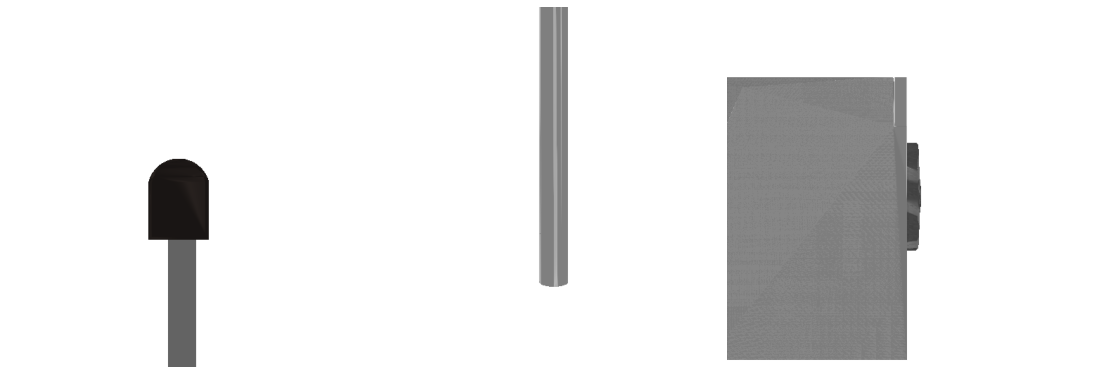

In [15]:
images_by_model_ids = shapenet_dataset.render(
    model_ids=[
        "1e4df43ee2f2da6967f9cc18b363cf72",
        "6f6ed9e0d29b64e714be24585075d395",
        "da0179a5b68f13586a6a687121d74e50"
    ],
    device=device,
    cameras=cameras,
    raster_settings=raster_settings,
    lights=lights,
)
image_grid(images_by_model_ids.cpu().numpy(), rows=1, cols=3, rgb=True)

We can also render models by their indices:

/usr/local/lib/python3.6/dist-packages/pytorch3d/io/mtl_io.py:96: UserWarning: Texture UV coordinates outside the range [0, 1].                 The integer part will be ignored to form a repeating pattern.
  warnings.warn(msg)


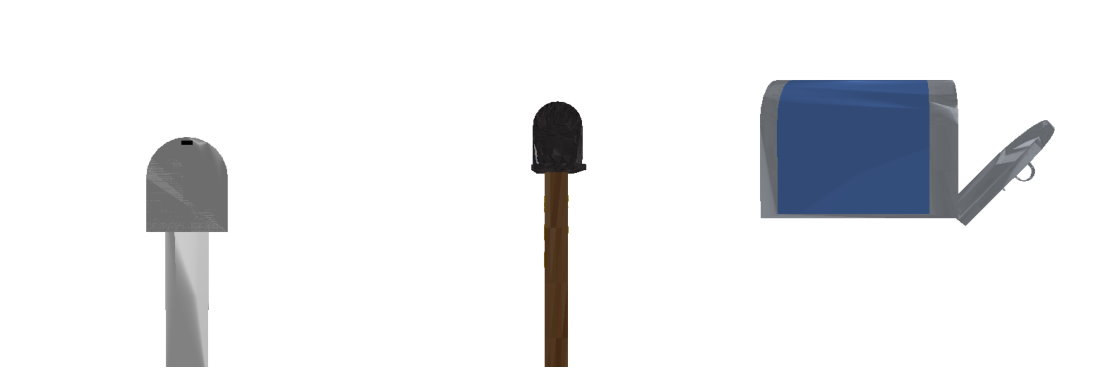

In [18]:
images_by_idxs = shapenet_dataset.render(
    idxs=list(range(100, 103)),
    device=device,
    cameras=cameras,
    raster_settings=raster_settings,
    lights=lights,
)
image_grid(images_by_idxs.cpu().numpy(), rows=1, cols=3, rgb=True)

Alternatively, if we are not interested in any particular models but would like see random models from some specific categories, we can do that by specifying `categories` and `sample_nums`. For example, if we would like to render 2 models from the category "faucet" and 3 models from the category "chair", we can do the following:

/usr/local/lib/python3.6/dist-packages/pytorch3d/io/mtl_io.py:96: UserWarning: Texture UV coordinates outside the range [0, 1].                 The integer part will be ignored to form a repeating pattern.
  warnings.warn(msg)


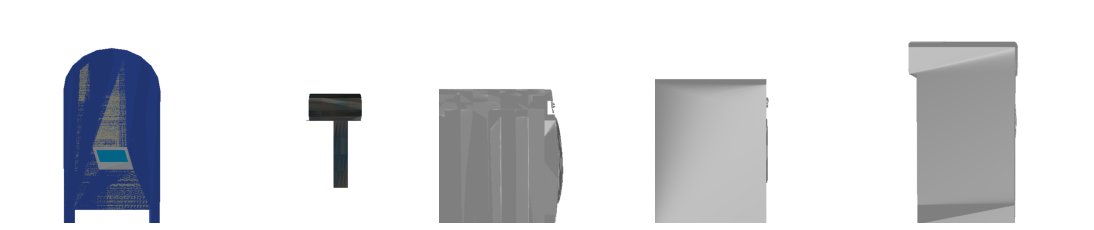

In [19]:
images_by_categories = shapenet_dataset.render(
    categories=["mailbox", "washer"], #remote
    sample_nums=[2, 3],
    device=device,
    cameras=cameras,
    raster_settings=raster_settings,
    lights=lights,
)
image_grid(images_by_categories.cpu().numpy(), rows=1, cols=5, rgb=True)

If we are not interested in any particular categories and just would like to render some random models from the whole dataset, we can set the number of models to be rendered in `sample_nums` and not specify any `categories`:

/usr/local/lib/python3.6/dist-packages/pytorch3d/io/mtl_io.py:96: UserWarning: Texture UV coordinates outside the range [0, 1].                 The integer part will be ignored to form a repeating pattern.
  warnings.warn(msg)


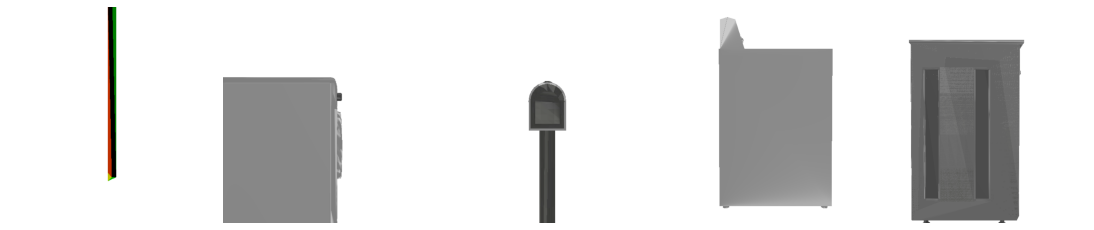

In [21]:
random_model_images = shapenet_dataset.render(
    sample_nums=[5],
    device=device,
    cameras=cameras,
    raster_settings=raster_settings,
    lights=lights,
)
image_grid(random_model_images.cpu().numpy(), rows=1, cols=5, rgb=True)

# Part 3 - Plotly Visualization

PyTorch3D has a differentiable renderer which allows us to generate images and take derivatives of the images with respect to the scene parameters. A differentiable renderer is very powerful, but it more computing intensive and it requires some setup. 

In this assignment, we only want to visualize the meshes, so we'll use Ploty for that. 

In [24]:
from pytorch3d.vis.plotly_vis import AxisArgs, plot_batch_individually, plot_scene
from pytorch3d.vis.texture_vis import texturesuv_image_matplotlib

3.0. Show the number of instances in our subset of the ShapeNet dataset using the function `len` on `shapenet_dataset`

3.1. Create a Meshes object by taking it's vertices and faces from a shapenet model. Name your variable `myfirstmesh` so the code on the cell below display correctly.


In [38]:
##############################################################################
# Code for 3.0-3.1.
##############################################################################

As You just saw, the function `plot_scene` takes a dictionary of subplots and returns a plotly figure. Each subplot is a dictionary of kind `name: mesh`. 

3.2. You can render textured models using Ploty. Create a Meshes object passing `verts`, `faces` and `textures` arguments. `textures` must be a `TexturesVertex` object. It's not an easy task to create a `TextureVertex` directly from the ShapeNet model, so for now we suggest you create a simple tensor like a noisy color or other kind of pattern you can control. 

3.3. Create another Meshes object from ShapeNet and show both models in the same subplot. 
  
  **Extra: you can create a batch of Meshes instead of two or more individual Meshes objects. To do so, note that the arguments to build a Meshes instance are, in fact, lists.**


3.4. Each mesh is represented in its own coordinate system. This way, when you put them in the same subplot, they will overlap. This time, create a new subplot and plot the meshes. 

  **Extra: if you created a batch of Meshes, use the function** `plot_batch_individually`.


3.5. Experiment changing the figure size using `fig.update_layout(height:int,width:int)` . Experiment adding the arguments below to the `plot_scene` or `plot_batch_individually` functions.
```
  (...)
  xaxis={"backgroundcolor":"rgb(200, 200, 230)"},
  yaxis={"backgroundcolor":"rgb(230, 200, 200)"},
  zaxis={"backgroundcolor":"rgb(200, 230, 200)"},
  axis_args=AxisArgs(showgrid=True)
  (...)
  ```

In [ ]:
##############################################################################
# Code for 3.2-3.5.
##############################################################################